# This Notebook Simulates and Animates Swarm Spacing with an LJ-Potential

## Required Imports

In [10]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt

from fish import Fish

from interaction import Interaction
from environment import Environment
from channel import Channel
from observer import Observer
from dynamics import Dynamics

from utils import generate_distortion, generate_fish, run_simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation of Swarm Spacing

Change parameters here, in particular `intial_spread` and `target_dist`.

In [11]:
run_time = 60 # in seconds
num_fish = 7
arena_size = np.array([1780, 1780, 1170])
arena_center = arena_size / 2.0
initial_spread = 250
fish_pos = initial_spread * np.random.rand(num_fish, 3) + arena_center - initial_spread / 2.0
fish_vel = np.zeros((num_fish, 3))
fish_phi = math.pi * np.random.rand(num_fish, 1)
fish_vphi = np.zeros((num_fish, 1))
clock_freqs = 1
verbose = False

distortion = generate_distortion(type='none', magnitude=130, n=math.ceil(arena_size[0]/10)+1, show=False)
environment = Environment(
    arena_size=arena_size,
    node_pos=fish_pos,
    node_vel=fish_vel,
    node_phi=fish_phi,
    node_vphi=fish_vphi,
    distortion=distortion,
    prob_type='binary',
    conn_thres=3000,
    conn_drop=1,
    noise_magnitude=10,
    verbose=verbose
)
interaction = Interaction(environment, verbose=verbose)
channel = Channel(environment)
dynamics = Dynamics(environment, clock_freq=clock_freqs)

fish = generate_fish(
    n=num_fish, 
    channel=channel, 
    interaction=interaction,
    dynamics=dynamics,
    w_blindspot=50,
    r_blocking=65,
    target_dist=1000,
    lim_neighbors=[0,num_fish],
    neighbor_weights=1.0,
    fish_max_speeds=130,
    clock_freqs=clock_freqs,
    verbose=verbose
)
channel.set_nodes(fish)

observer = Observer(fish=fish, environment=environment, channel=channel)
    
run_simulation(fish=fish, observer=observer, run_time=run_time, dark=False, white_axis=False, no_legend=True)

Please wait patiently 60 seconds. Thanks.
It's time to say bye bye!


## Evaluate Spacing over Time

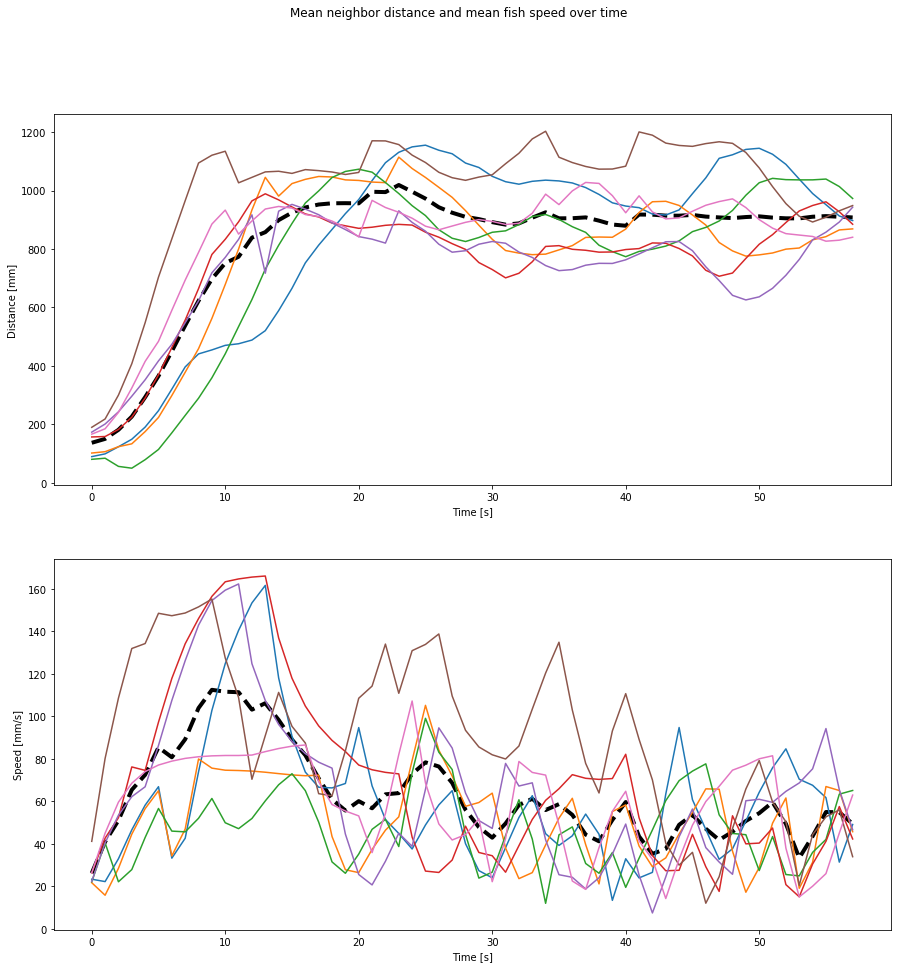

The initial mean neighbor distance is 137.1mm. The initial mean robot speed is 0.0mm/s
The final mean neighbor distance is 907.9mm. The final mean robot speed is 49.4mm/s
The increase in mean neighbor distance is 662.1%


In [12]:
d_mean = observer.d_mean
d_mean_indv = observer.d_mean_indv

data = np.zeros((6, run_time, num_fish))
data[0, :, :] = np.transpose(np.array(observer.x))
data[1, :, :] = np.transpose(np.array(observer.y))
data[2, :, :] = np.transpose(np.array(observer.z))
data[3, :, :] = np.transpose(np.array(observer.vx))
data[4, :, :] = np.transpose(np.array(observer.vy))
data[5, :, :] = np.transpose(np.array(observer.vz))

v_indv = np.array([data[3, :, :], data[4, :, :], data[5, :, :]])
v_indv_magnitude = np.linalg.norm(v_indv, axis=0)
v_mean_magnitude = np.sum(v_indv_magnitude, axis=1)/num_fish

fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(d_mean[2:], '--k', LineWidth=4)
for ii in range(num_fish):
    axs[0].plot(d_mean_indv[ii][2:])
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Distance [mm]')

axs[1].plot(v_mean_magnitude[2:], '--k', LineWidth=4)
for ii in range(num_fish):
    axs[1].plot(v_indv_magnitude[2:, ii])
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Speed [mm/s]')

fig.suptitle('Mean neighbor distance and mean fish speed over time')
plt.show()

print('The initial mean neighbor distance is {0:.1f}mm. The initial mean robot speed is {1:.1f}mm/s'.format(d_mean[2], v_mean_magnitude[0]))
print('The final mean neighbor distance is {0:.1f}mm. The final mean robot speed is {1:.1f}mm/s'.format(d_mean[-1], v_mean_magnitude[-1]))
print('The increase in mean neighbor distance is {0:.1f}%'.format((d_mean[-1]/d_mean[2])*100))

## Prepare Data for Animation

In [4]:
# Get fish data from observer
data = np.zeros((6, run_time, num_fish+2))
data[0, :, :-2] = np.transpose(np.array(observer.x))
data[1, :, :-2] = np.transpose(np.array(observer.y))
data[2, :, :-2] = np.transpose(np.array(observer.z))
data[3, :, :-2] = np.transpose(np.array(observer.vx))
data[4, :, :-2] = np.transpose(np.array(observer.vy))
data[5, :, :-2] = np.transpose(np.array(observer.vz))

# Add center
data[0, :, -2] = 1780/2
data[1, :, -2] = 1780/2
data[2, :, -2] = 1170/2+45
data[3, :, -2] = 0
data[4, :, -2] = 0
data[5, :, -2] = -1
data[0, :, -1] = 1780/2
data[1, :, -1] = 1780/2
data[2, :, -1] = 1170/2-45
data[3, :, -1] = 0
data[4, :, -1] = 0
data[5, :, -1] = 1

## Save Data

In [90]:
np.save('ljpot', data)

## Animate Simulated Data

Change the speed-up factor of the animation in the variable `speed`.

In [5]:
# Imports
import ipyvolume as ipv
from ipyvolume.moviemaker import MovieMaker
import ipywidgets as widgets
import ipywebrtc as webrtc
import matplotlib.cm as cm
import time

# Data handling
x, y, z, vx, vy, vz = data
speed = 1 # speed up animation 10 times

# Colors
v = np.sqrt(x**2 + y**2 + z**2)
v -= v.min(); v /= v.max();
colors = np.array([cm.Blues(k) for k in v])
colors[:, -2:, :] = cm.Reds(0.5) # center is red

# Figure
fig = ipv.figure()
ipv.xlim(0, 1780)
ipv.ylim(0, 1780)
ipv.zlim(0, 1170)
ipv.style.use('dark')
quiver = ipv.quiver(x, y, z, vx, vy, vz, size=10, color=colors[:,:,:3])
ipv.animation_control(quiver, interval=1000/speed)
ipv.show()

## Save Animation as html

In [6]:
ipv.save('ljpot.html')